/home/nazara/Data2/UCU/CV_GENAI_2_3/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nazara/Data2/UCU/CV_GENAI_2_3/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image class: 3


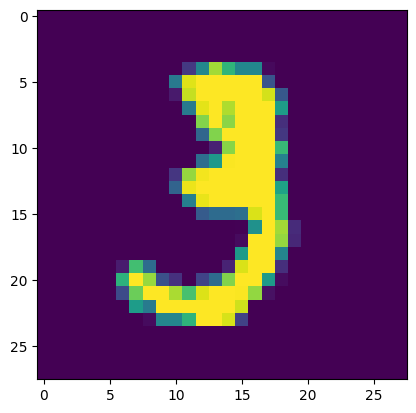

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from schedulers import LinearScheduler,CosineScheduler
from unet import UNetTimed, UNetTimedWithVAEConditioned
from schedulers import DDPM
from schedulers import DDIMSampler, DDPMSampler
from fid import FIDScore


fid_calculator = FIDScore()

mnist_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True, 
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


mnist_dataset.data[10]

plt.imshow(mnist_dataset.data[10])
print(f"Image class: {mnist_dataset.targets[10]}")

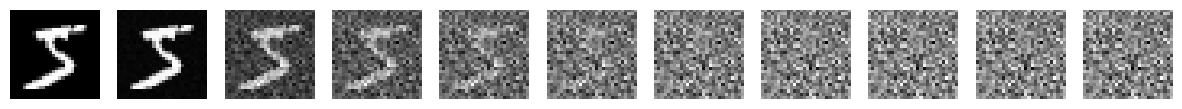

In [2]:
ddpm = DDPMSampler(0.001, 0.025, 1000)

mnist_dataset[0][0]
noise = torch.randn_like(mnist_dataset[0][0])
images_progression = [mnist_dataset[0][0][0]]
for i in range(0,1000,100):
    res = ddpm.add_noise(mnist_dataset[0][0],[i],noise)
    images_progression.append(res[0][0])

fig, axes = plt.subplots(1, len(images_progression), figsize=(15, 5))
for i, img in enumerate(images_progression):
    axes[i].imshow(img.cpu().numpy(), cmap="gray")
    axes[i].axis("off")
plt.show()

In [3]:
# Create DataLoader
batch_size = 128

dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True,drop_last = True)

# Initialize model, optimizer and loss function
unet = UNetTimed() #UNetTimedWithVAEConditioned(vae=None,use_condition=False)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
mse_loss = torch.nn.MSELoss()

# Training hyperparameters
num_epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)
total_params = sum(p.numel() for p in unet.parameters())
print(f"Total parameters: {total_params:,}")
# DDPM instance

# Training loop
# Lists to store loss and FID history
loss_history = []
fid_history = []

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Generate random noise
        noise = torch.randn_like(images).to(device)
        
        # Generate random timesteps
        batch_size = images.shape[0]
        timesteps = torch.randint(0, ddpm.max_timestep, (batch_size,), device=device)
        
        # Add noise to images according to timesteps
        noised_images = ddpm.add_noise(images, timesteps, noise)
        
        # Predict noise
        predicted_noise = unet(noised_images, timesteps)
        
        # Calculate loss
        loss = mse_loss(predicted_noise, noise)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.4f}')
    
    # Compute average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)  # Store loss history
    print(f'Epoch {epoch} | Average Loss: {avg_loss:.4f}')

    # Generate samples using DDPM 
    with torch.no_grad():
        sample_images = ddpm.sample(
            model=unet.eval(),
            n_samples=batch_size, 
            img_size=(1, 28, 28),  # For MNIST
            device=device,
            steps=1000  
        )

    # Get a batch of real images for FID calculation
    real_images = next(iter(dataloader))[0]
    real_images = real_images.to(device)

    # Compute FID score
    assert real_images.shape == sample_images.shape, f"Wrong shapes real = {real_images.shape}, sampled = {sample_images.shape}"
    fid_score = fid_calculator.calculate_fid(real_images.cpu(), sample_images.cpu())
    fid_history.append(fid_score)  # Store FID history
    print(f'Epoch {epoch} | FID Score: {fid_score:.4f}')

    #  Save checkpoint
    # if (epoch + 1) % 10 == 0:
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': unet.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': avg_loss,
    #     }, f'ddpm_checkpoint_epoch_{epoch+1}.pt')

Total parameters: 9,544,437
Epoch 0 | Batch 0 | Loss: 1.4896
Epoch 0 | Batch 100 | Loss: 0.1148
Epoch 0 | Batch 200 | Loss: 0.0784
Epoch 0 | Batch 300 | Loss: 0.0705
Epoch 0 | Batch 400 | Loss: 0.0581
Epoch 0 | Average Loss: 0.1248
Epoch 0 | FID Score: 69.7522
Epoch 1 | Batch 0 | Loss: 0.0577
Epoch 1 | Batch 100 | Loss: 0.0536
Epoch 1 | Batch 200 | Loss: 0.0340
Epoch 1 | Batch 300 | Loss: 0.0379
Epoch 1 | Batch 400 | Loss: 0.0453
Epoch 1 | Average Loss: 0.0434
Epoch 1 | FID Score: 90.0503
Epoch 2 | Batch 0 | Loss: 0.0389
Epoch 2 | Batch 100 | Loss: 0.0368
Epoch 2 | Batch 200 | Loss: 0.0401
Epoch 2 | Batch 300 | Loss: 0.0392
Epoch 2 | Batch 400 | Loss: 0.0390
Epoch 2 | Average Loss: 0.0368
Epoch 2 | FID Score: 44.6352
Epoch 3 | Batch 0 | Loss: 0.0345
Epoch 3 | Batch 100 | Loss: 0.0393
Epoch 3 | Batch 200 | Loss: 0.0337
Epoch 3 | Batch 300 | Loss: 0.0291
Epoch 3 | Batch 400 | Loss: 0.0365
Epoch 3 | Average Loss: 0.0328
Epoch 3 | FID Score: 31.1413
Epoch 4 | Batch 0 | Loss: 0.0335
Epoch 4

KeyboardInterrupt: 

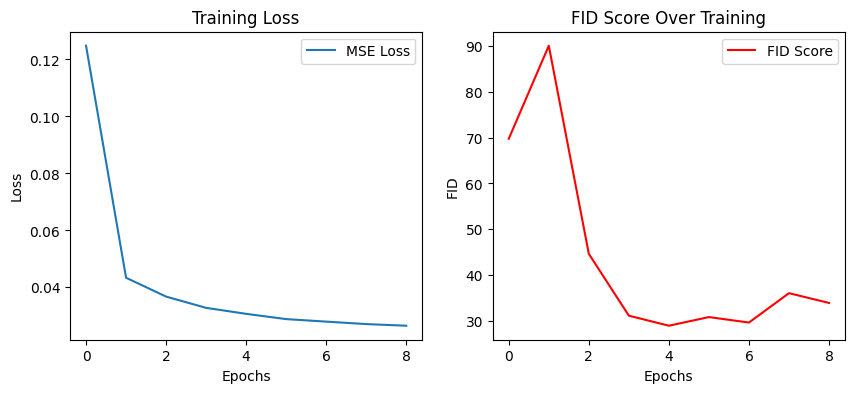

In [4]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="MSE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fid_history, label="FID Score", color='r')
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.title("FID Score Over Training")
plt.legend()

plt.show()

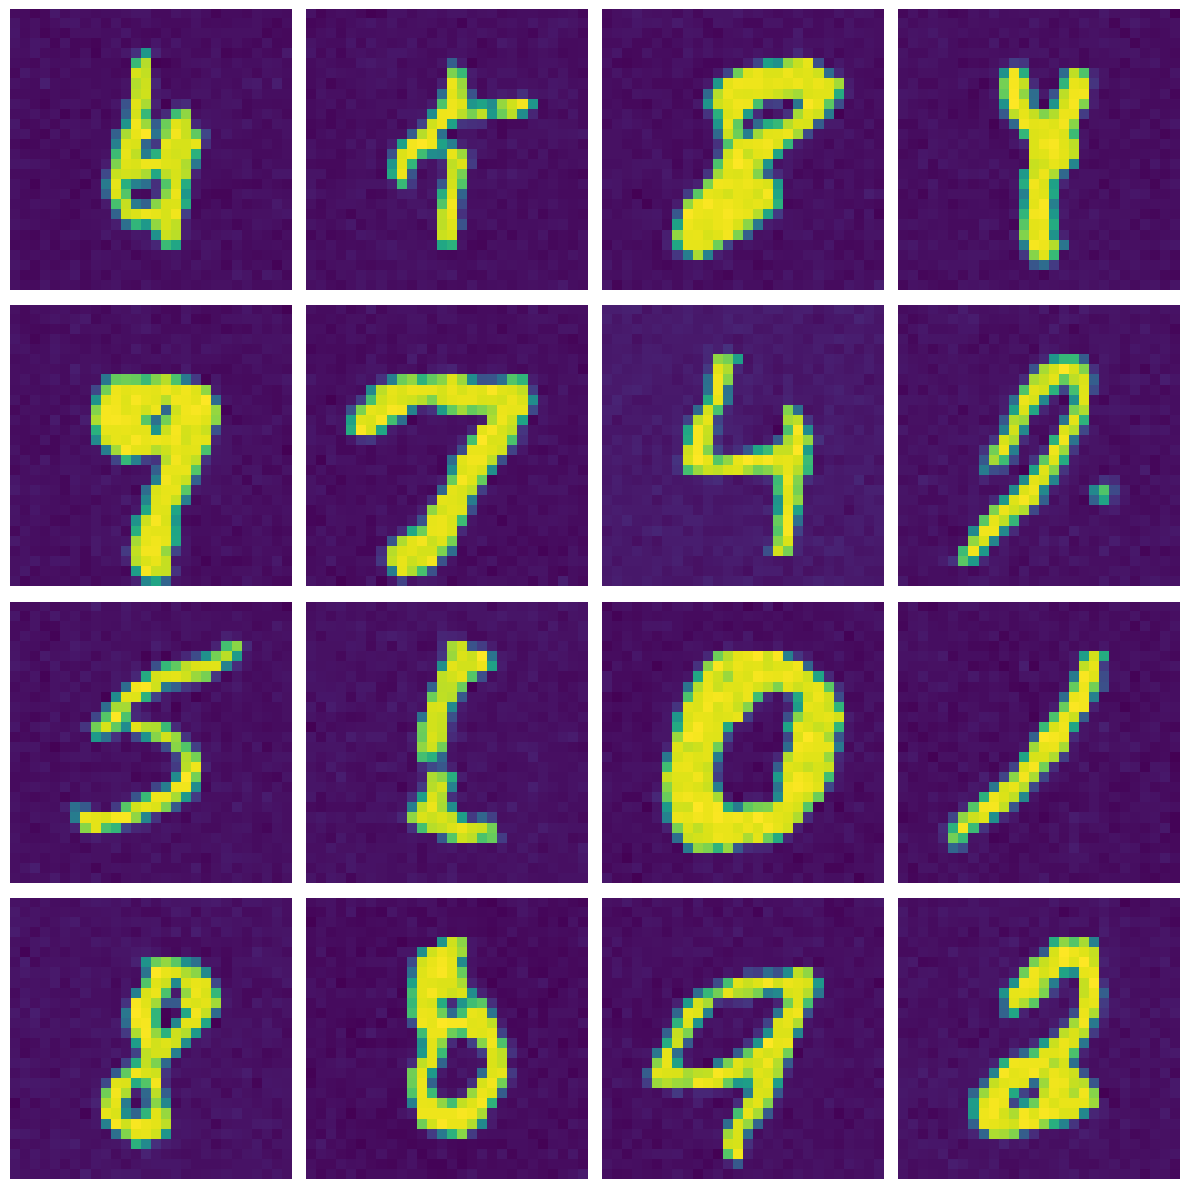

In [5]:
sampler = DDPMSampler(0.001, 0.025, 1000)
sample_images = sampler.sample(
    model=unet.train(),
    n_samples=128,
    img_size=(1, 28, 28),  # For MNIST
    device=device,
    steps=1000 # Can use fewer steps than training
)


# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = sample_images[i, 0].cpu().numpy()
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()




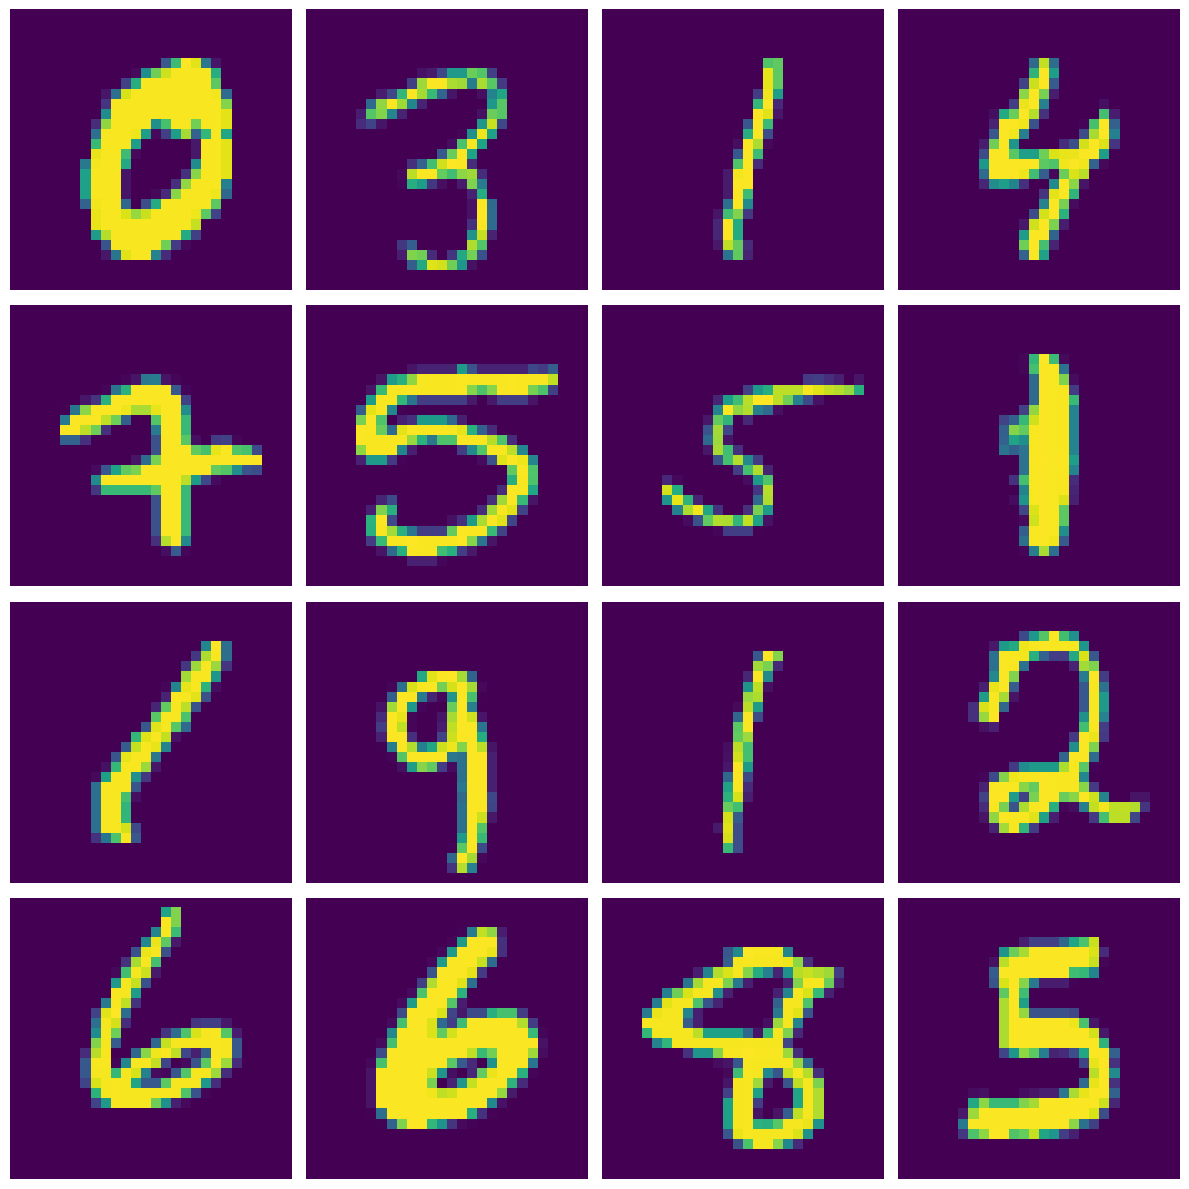

In [ ]:

# Get 16 random indices
random_indices = torch.randint(0, len(mnist_dataset), (16,))

# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each random sample
for i, idx in enumerate(random_indices):
    plt.subplot(4, 4, i + 1)
    img = mnist_dataset.data[idx].numpy()
    plt.imshow(img)
    # plt.title(f"Class: {mnist_dataset.targets[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


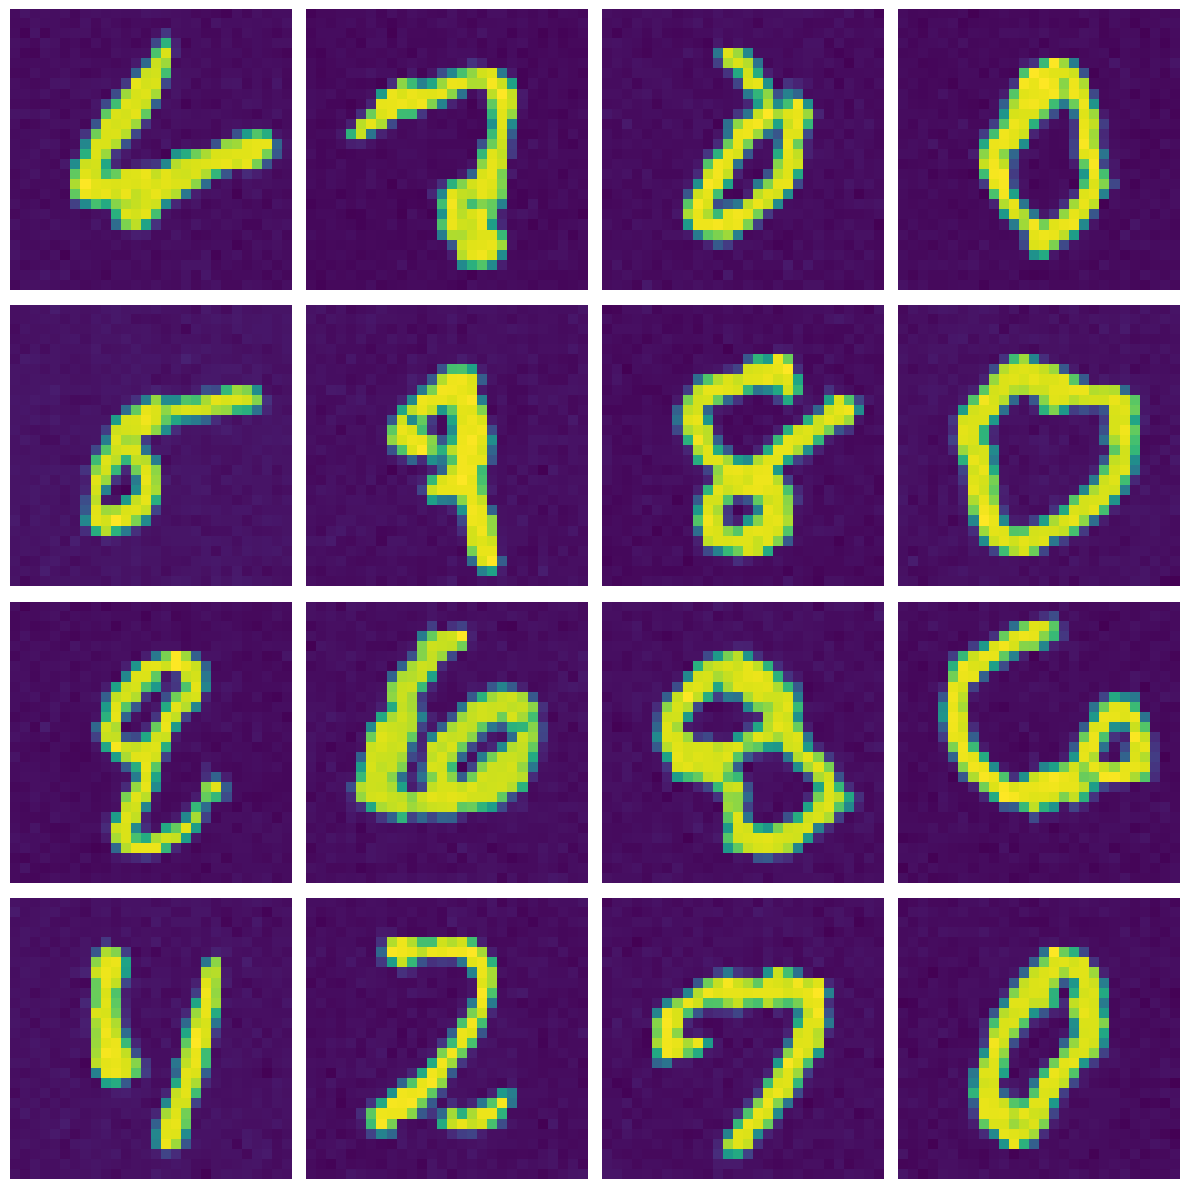

In [20]:
sampler = DDIMSampler(0.001, 0.025, 1000)
sample_images = sampler.sample(
    model=unet.eval(),
    n_samples=128,
    img_size=(1, 28, 28),  # For MNIST
    device=device,
    steps=100, # Can use fewer steps than training
    eta = 0.3
)


# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = sample_images[i, 0].cpu().numpy()
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()